In [1]:
import kagglehub

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import networkx as nx

In [2]:
# Download latest version
path = kagglehub.dataset_download("marsalanakhtar/ais-data-for-ships")

print("Path to dataset files:", path)
ais_data = pd.read_csv(f"{path}/AIS_2022_03_31.csv")

Path to dataset files: C:\Users\JWHardy\.cache\kagglehub\datasets\marsalanakhtar\ais-data-for-ships\versions\1


In [3]:
ais_data.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,367702220,2022-03-31T00:00:01,29.78763,-95.08070,0.1,226.5,340.0,JOE B WARD,NaN,WDI4808,31.0,12.0,21.0,8.0,NaN,57.0,A
1,671226100,2022-03-31T00:00:01,25.77626,-80.20320,3.2,143.7,511.0,RELIANCE II,IMO9221322,5VHS7,79.0,0.0,52.0,12.0,2.5,70.0,A
2,367767250,2022-03-31T00:00:01,29.31623,-94.78829,4.5,228.1,511.0,GLEN K,NaN,WDJ3358,52.0,0.0,0.0,0.0,0.0,52.0,A
3,338327436,2022-03-31T00:00:03,47.29634,-122.42233,0.0,360.0,511.0,COOL KAT,IMO0000000,NaN,36.0,NaN,15.0,3.0,NaN,NaN,B
4,367452810,2022-03-31T00:00:06,29.32824,-94.77391,2.6,319.2,511.0,JOHN W JOHNSON,IMO9602344,WDF4516,60.0,0.0,80.0,19.0,3.0,60.0,A


In [4]:
import pandas as pd

# Load the CSV
df = ais_data

# Ensure BaseDateTime is a datetime object for sorting
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

# Sort by MMSI and time
df = df.sort_values(["MMSI", "BaseDateTime"])

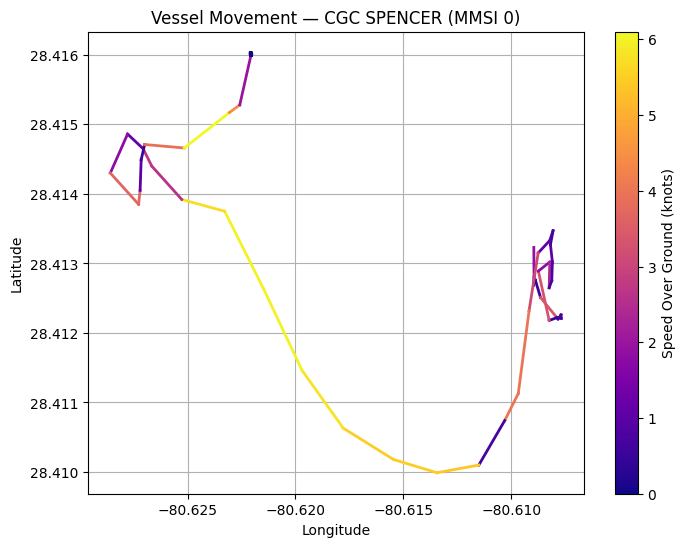

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Example assumes your dataframe is already defined and sorted
mmsi = df["MMSI"].iloc[0]
vessel = df[df["MMSI"] == mmsi].copy()
vessel["BaseDateTime"] = pd.to_datetime(vessel["BaseDateTime"])
vessel["SOG"] = pd.to_numeric(vessel["SOG"], errors="coerce")
vessel = vessel.sort_values("BaseDateTime")

# Normalize speed and set color map
norm = plt.Normalize(vessel["SOG"].min(), vessel["SOG"].max())
colors = plt.cm.plasma(norm(vessel["SOG"]))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the path with colored segments
for i in range(len(vessel) - 1):
    ax.plot(
        vessel["LON"].iloc[i:i+2],
        vessel["LAT"].iloc[i:i+2],
        color=colors[i],
        linewidth=2
    )

# Create the scalar mappable and attach it to the same axis
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])

# Add colorbar tied to that axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Speed Over Ground (knots)")

# Labels and title
name = vessel["VesselName"].iloc[0] if "VesselName" in vessel.columns else mmsi
ax.set_title(f"Vessel Movement — {name} (MMSI {mmsi})")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

plt.show()


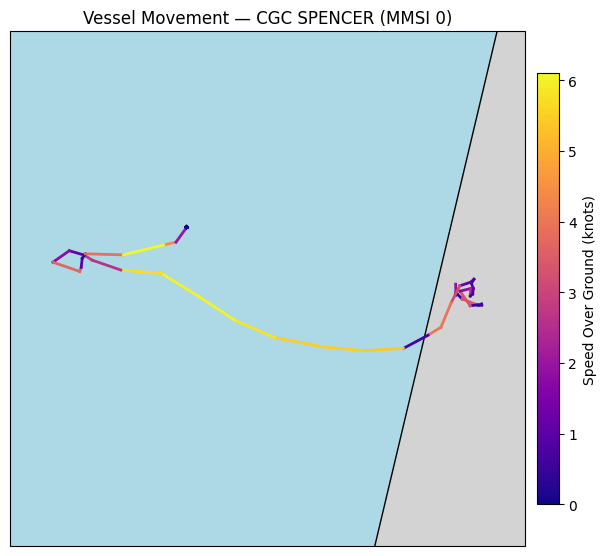

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- Extract and prepare vessel data ---
mmsi = df["MMSI"].iloc[0]
vessel = df[df["MMSI"] == mmsi].copy()
vessel["BaseDateTime"] = pd.to_datetime(vessel["BaseDateTime"])
vessel["SOG"] = pd.to_numeric(vessel["SOG"], errors="coerce")
vessel = vessel.sort_values("BaseDateTime")

# --- Normalize speeds for color ---
norm = plt.Normalize(vessel["SOG"].min(), vessel["SOG"].max())
colors = plt.cm.plasma(norm(vessel["SOG"]))

# --- Determine map extent ---
lat_min, lat_max = vessel["LAT"].min(), vessel["LAT"].max()
lon_min, lon_max = vessel["LON"].min(), vessel["LON"].max()

# Padding for visibility
lat_pad = (lat_max - lat_min) * 0.1 or 0.5
lon_pad = (lon_max - lon_min) * 0.1 or 0.5

lat_min -= lat_pad
lat_max += lat_pad
lon_min -= lon_pad
lon_max += lon_pad

# --- Force square extent ---
lat_span = lat_max - lat_min
lon_span = lon_max - lon_min
max_span = max(lat_span, lon_span)
center_lat = (lat_max + lat_min) / 2
center_lon = (lon_max + lon_min) / 2

lat_min = center_lat - max_span / 2
lat_max = center_lat + max_span / 2
lon_min = center_lon - max_span / 2
lon_max = center_lon + max_span / 2

extent = [lon_min, lon_max, lat_min, lat_max]

# --- Initialize Cartopy map ---
fig = plt.figure(figsize=(8, 8))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent(extent, crs=proj)

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.LAKES, facecolor="lightblue")
ax.add_feature(cfeature.RIVERS)

# --- Plot path with color-coded speed ---
for i in range(len(vessel) - 1):
    ax.plot(
        vessel["LON"].iloc[i:i+2],
        vessel["LAT"].iloc[i:i+2],
        color=colors[i],
        linewidth=2,
        transform=ccrs.PlateCarree()
    )

# --- Colorbar ---
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="vertical", pad=0.02, shrink=0.7)
cbar.set_label("Speed Over Ground (knots)")

# --- Title ---
name = vessel["VesselName"].iloc[0] if "VesselName" in vessel.columns else mmsi
plt.title(f"Vessel Movement — {name} (MMSI {mmsi})")

plt.show()


In [28]:
types = set(df["VesselType"].dropna())


In [30]:
print(len(types))
print(types)

63
{0.0, 1.0, 3.0, 7.0, 9.0, 10.0, 16.0, 18.0, 19.0, 20.0, 23.0, 25.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 45.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 59.0, 60.0, 65.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 200.0, 74.0, 75.0, 73.0, 76.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 89.0, 90.0, 91.0, 94.0, 95.0, 97.0, 98.0, 99.0, 255.0}


In [36]:
x = len(df)
y = len(df["VesselType"].dropna())

In [37]:
x-y

817

In [38]:
df = df.dropna(subset=["VesselType"])


In [39]:
df["VesselType"].isna().sum()


0

In [51]:
def classify_vessel_type(vessel_code):
    if 20 <= vessel_code <= 24:
        return "WIG (Wing in Ground craft)"
    elif 40 <= vessel_code <= 49:
        return "HSC (High-Speed Craft)"
    elif 60 <= vessel_code <= 69:
        return "Passenger Ship"
    elif 70 <= vessel_code <= 79:
        return "Cargo Ship"
    elif 80 <= vessel_code <= 89:
        return "Tanker"
    elif 90 <= vessel_code <= 99:
        return "Other Type of Ship"
    else:
        return "UnknownVesselType"

# Apply classification to the DataFrame
df["VesselType_Str"] = df["VesselType"].apply(classify_vessel_type)


In [52]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselType,Status,Length,Width,Draft,Cargo,VesselType_Str
3098,0,2022-03-31 00:00:08,28.41323,-80.60895,1.9,176.9,511.0,55.0,5.0,82.0,12.0,0.0,0.0,UnknownVesselType
6229,0,2022-03-31 00:01:18,28.41280,-80.60894,0.1,0.0,511.0,55.0,5.0,82.0,12.0,0.0,0.0,UnknownVesselType
12935,0,2022-03-31 00:02:27,28.41269,-80.60896,0.4,0.0,511.0,55.0,5.0,82.0,12.0,0.0,0.0,UnknownVesselType
14873,0,2022-03-31 00:03:37,28.41276,-80.60888,0.5,0.0,511.0,55.0,5.0,82.0,12.0,0.0,0.0,UnknownVesselType
25482,0,2022-03-31 00:05:59,28.41251,-80.60864,3.4,118.2,511.0,55.0,5.0,82.0,12.0,0.0,0.0,UnknownVesselType


In [68]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# --- Data prep ---
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])
df = df.sort_values(["MMSI", "BaseDateTime"])

# Create next-step targets
df["LAT_next"] = df.groupby("MMSI")["LAT"].shift(-1)
df["LON_next"] = df.groupby("MMSI")["LON"].shift(-1)

# Remove rows with missing targets
df = df.dropna(subset=["LAT_next", "LON_next"])

# Split train/test: all but last record per vessel
train = df.groupby("MMSI").apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
test  = df.groupby("MMSI").apply(lambda x: x.iloc[-1:]).reset_index(drop=True)

# --- Features and target ---
features = ["LAT", "LON", "SOG", "COG", "Heading", "Length", "Width", "Draft"]
target = ["LAT_next", "LON_next"]

# --- Model pipeline (handles NaNs automatically) ---
model = make_pipeline(
    IterativeImputer(random_state=42, max_iter=10),
    LinearRegression()
)

# Fit and predict
model.fit(train[features], train[target])
pred = model.predict(test[features])
test["LAT_pred"], test["LON_pred"] = pred[:, 0], pred[:, 1]

# --- Distance evaluation ---
R_earth = 6371000  # meters
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R_earth * c

test["error_m"] = haversine(
    test["LAT_next"], test["LON_next"],
    test["LAT_pred"], test["LON_pred"]
)
test["error_ft"] = test["error_m"] * 3.28084

# --- Metrics ---
mean_error = test["error_ft"].mean()
rmse_ft = np.sqrt((test["error_ft"] ** 2).mean())

print(f"Mean Error: {mean_error:.2f} ft")
print(f"RMSE: {rmse_ft:.2f} ft")


C:\Users\JWHardy\AppData\Local\Temp\ipykernel_15700\3054113577.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df.groupby("MMSI").apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
C:\Users\JWHardy\AppData\Local\Temp\ipykernel_15700\3054113577.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test  = df.groupby("MMSI").apply(lambda x: x.iloc[-1:]).reset_index(drop=True)
C:\Users\JWHardy\anaconda3\mya

Mean Error: 2092.04 ft
RMSE: 29488.79 ft
